In [40]:
# pip3 install opencv-python numpy matplotlib
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from scipy.signal import find_peaks



In [41]:
import cv2
import numpy as np

#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
def contourFinder(img_path):
    contour = []
    image_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cropped = [];
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
    
        if (w*h < 40*40):
            continue
        if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
            continue
        contour.append(c)
        cropped.append(image_orig[y:y+h, x:x+w])
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
    i=0
    for k in cropped:
        cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
        i= i+1
    cv2.waitKey()
    return [i, contour]

In [42]:
def blackAndWhite(file):
    img = cv2.imread(file)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width, *rest= img.shape

    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                img[i, j] =255
            else:
                img[i, j] = 0
    return img

In [43]:
def calculateYProjection(array):
    img_row_sum = []
    for i in range(len(array)):
        img_row_sum.append(np.sum(array[i],axis=1).tolist())
    return img_row_sum

In [44]:
def calculatePeaks(array):
    peaks_of_image = []
    for i in range(len(array)):
        x =array[i]
        peaks, _ = find_peaks(x, distance=15)
        peaks_of_image.append(peaks)
    return peaks_of_image

In [51]:
def makeLines(array, peaks_image):
    images = array  
    for k,image in enumerate(array):
        newImage = image.copy()
        height, width= newImage.shape
        for i in range(height):
            if(i in peaks_image[k]):
                for j in range(width):
                    try:
                        newImage[i,j] = 255
                        newImage[i-1,j] = 255
                        newImage[i+1,j] = 255
                        newImage[i-2,j] = 255
                        newImage[i+2,j] = 255
                        newImage[i-3,j] = 255
                        newImage[i+3,j] = 255
                    except Exception as e:
                        continue
                        print("out of boundaries")
        plt.imshow(newImage, cmap='Greys_r')
        cv2.imwrite('linesdetected/cropped_image' + str(k) +'.png', newImage)

In [52]:
def assembleImage(original_image_size , contours, filename):

    img = Image.new('RGB', original_image_size[::-1] )
    plt.imshow(img, cmap='Greys_r')
    for idx, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        cr= Image.open('linesdetected/cropped_image' + str(idx) +'.png')
        plt.imshow(cr,cmap='Greys_r' )
        img.paste(cr, (x,y))
    img.save("output/" + filename[:-4] + "predicted.png")

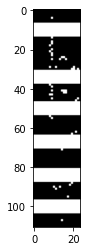

In [53]:
import os
import glob
direc= os.getcwd()
for img in glob.glob(direc + '/images' + '/*binarized*.jpg'):
    image_orig = cv2.imread(img)
    number_of_images, contours = contourFinder(img)

    array = []
    img_row_sum = []
    peaks_image = []


    for filename in glob.glob(direc + '/cropped' + '/*.png'):
        array.append(blackAndWhite(filename))
    
    img_row_sum = calculateYProjection(array)  

    peaks_image= calculatePeaks(img_row_sum)

    makeLines(array, peaks_image)

    k =image_orig.shape[:-1]
    assembleImage(k, contours, img.split("\\")[-1])


In [ ]:
# Source: https://medium.com/analytics-vidhya/binarization-of-image-using-numpy-65df2b82e189
def read_this(image_file, gray_scale=False):
    image_src = cv.imread(image_file)
    if gray_scale:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2GRAY)
    else:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2RGB)
    return image_src

In [ ]:
def ApplyOtsu(image_file, thresh_val=127, gray_scale=True):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    #blur = cv.GaussianBlur(image_src,(5,5),0)
    th, image_b = cv.threshold(image_src, 127, 255, cv.THRESH_BINARY+ cv.THRESH_OTSU)
    return Image.fromarray(image_b)

In [ ]:
def save_image(image, old_name, dir):
    if('_binarized' not in old_name):
        index = dir.find('.jpg')
        final_string = dir[:index] + '_binarized' + dir[index:]
        image.save(final_string)
    

def main():
    dir = os.getcwd()
    try:
        #assuming this file is one directory upper than images
        directory = os.fsencode(dir + '/images/')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                image_dir = dir + '/images/' + filename
                binarized_image = ApplyOtsu(image_file=image_dir)
                save_image(binarized_image, filename, image_dir)
            else:
                continue
                
    except Exception as e:
        print(e)

if __name__ == "__main__":
    main()  

In [ ]:
import cv2
import numpy as np
contour = []
#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
def contourFinder(img_path):

    image_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cropped = [];
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
    
        if (w*h < 40*40):
            continue
        if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
            continue
        contour.append(c)
        cropped.append(image_orig[y:y+h, x:x+w])
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
    i=0
    for k in cropped:
        cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
        i= i+1
    cv2.waitKey()
    return i

In [ ]:
contourFinder("images/fmb-cb-55-050v_binarized.jpg")

In [ ]:
print(len(contour))

In [ ]:
import cv2
import numpy as np
#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
image_orig = cv2.imread('./images/fmb-cb-55-027v_binarized.jpg')
gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

cropped = [];
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    
    if (w*h < 40*40):
        continue
    if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
        continue

    cropped.append(image_orig[y:y+h, x:x+w])
    cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
i=0
for k in cropped:
    cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
    i= i+1
cv2.waitKey()

In [ ]:

import os
import glob
images = []
direc= os.getcwd()
for filename in glob.glob(direc + '/cropped' + '/*.png'):
    image1 = cv2.imread(filename)
    print("hi")
    print(image1)
    grayImage= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
#plt.imshow(grayImage)
    GaussianFilter= cv2.GaussianBlur(grayImage, (5,5), 0)
    _, binarizedImage = cv2.threshold(GaussianFilter, 127, 255, cv2.THRESH_BINARY)
    plt.figure()
    plt.imshow(binarizedImage, cmap='Greys_r')
    height, width= binarizedImage.shape

    for i in range(height):
        for j in range(width):
        # img[i, j] is the RGB pixel at position (i, j)
        # check if it's [0, 0, 0] and replace with [255, 255, 255] if so
            if binarizedImage[i, j] == 0:
                binarizedImage[i, j] =255
            else:
                binarizedImage[i, j] = 0
    images.append(binarizedImage)
    plt.imshow(binarizedImage, cmap='Greys_r')          

In [ ]:

img_row_sum = []
for i in range(len(images)):
    img_row_sum.append(np.sum(images[i],axis=1).tolist())
    #plt.figure(figsize=(5,5))
    #plt.show()


In [ ]:
#print(peaks_image)

In [ ]:
for k in range(len(images)):
    newImage = images[k].copy()
    height, width= newImage.shape
    print(newImage.shape)
    for i in range(height):
        if(i in peaks_image[k]):
            for j in range(width):
                newImage[i,j] = 255
                newImage[i-1,j] = 255
                newImage[i+1,j] = 255
                newImage[i-2,j] = 255
                newImage[i+2,j] = 255
                newImage[i-3,j] = 255
                newImage[i+3,j] = 255
    plt.imshow(newImage, cmap='Greys_r')
    cv2.imwrite('linesdetected/cropped_image' + str(k) +'.png', newImage)
        

In [ ]:
print(image_orig.shape[:-1])

In [ ]:
print(len(cnts))

In [ ]:
k =image_orig.shape[:-1]

img = Image.new('RGB', k[::-1] )
plt.imshow(img, cmap='Greys_r')
for idx, c in enumerate(contour):
    x,y,w,h = cv2.boundingRect(c)
    cr= Image.open('linesdetected/cropped_image' + str(idx) +'.png')
    plt.imshow(cr,cmap='Greys_r' )
    img.paste(cr, (x,y))
img.save("pasted.grid.png")

In [ ]:
image = cv2.imread('cropped_image4.png')

In [ ]:

cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
crop_img= cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

In [ ]:
import cv2
import numpy as np

# read image
img = cv2.imread("cropped_image4.png")
img = img[65:75, :].copy()

# convert img to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# invert polarity
gray = 255 - gray

# do adaptive threshold on gray image
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]

# Get contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
i = 1
for c in cnts:
    # create white image
    result = np.full_like(img, (255,255,255))
    # get bounding box
    x,y,w,h = cv2.boundingRect(c)
    # crop region of img using bounding box
    region = img[y:y+h, x:x+w]
    # save region to new image
    cv2.imwrite("black_region_{0}.png".format(i), region)
    i = i + 1


# display it
#cv2.imshow("IMAGE", img)
#cv2.imshow("GRAY", gray)
cv2.imshow("THRESHOLD", thresh)
cv2.waitKey(0)

In [ ]:
img=thresh
ret,gray = cv2.threshold(img,127,255,0)
gray2 = gray.copy()
mask = np.zeros(gray.shape,np.uint8)

In [ ]:
contours, hier = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if 200<cv2.contourArea(cnt)<5000:
        cv2.drawContours(img,[cnt],0,(0,255,0),2)
        cv2.drawContours(mask,[cnt],0,255,-1)

In [ ]:
cv2.imshow('IMG',gray2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
GaussianFilter= cv2.GaussianBlur(crop_img, (5,5), 0)
_, binarizedImage = cv2.threshold(GaussianFilter, 127, 255, cv2.THRESH_BINARY)

In [ ]:
height, width = binarizedImage.shape
for i in range(height-1):
    for j in range(width-1):
        # img[i, j] is the RGB pixel at position (i, j)
        # check if it's [0, 0, 0] and replace with [255, 255, 255] if so
        if crop_img[i, j] == 0:
            crop_img[i, j] =255
        else:
            crop_img[i, j] = 0
plt.imshow(crop_img, cmap='Greys_r')   

In [ ]:
import matplotlib.pyplot as plt

from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

# The original image is inverted as the object must be white.
image = invert(crop_img)

#chull = convex_hull_image(image)

contours, hier = cv2.findContours(image,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if 200<cv2.contourArea(cnt)<5000:
        cv2.drawContours(img,[cnt],0,(0,255,0),2)
        cv2.drawContours(mask,[cnt],0,255,-1)

In [ ]:
import cv2


image= crop_img
original_image= image


edges= cv2.Canny(original_image, 50,200)


contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


for cnt in contours:
    hull= cv2.convexHull(cnt)
    cv2.drawContours(image, [hull],0,(0,255,0),2)
    cv2.imshow('Convex Hull', image)


In [ ]:
from scipy.signal import argrelextrema
data = np.array(img_row_sum)

maximums = argrelextrema(data, np.greater, order =2)

print(maximums)


In [ ]:
height, width = binarizedImage.shape
print('width : ', width)
print('height : ', height)
horizontal_projection = np.sum(binarizedImage, axis=1);
print(horizontal_projection)

In [ ]:
horizontal_projection = np.sum(image1, axis=1)
print(horizontal_projection)
print(image1.shape)
blankImage = np.zeros((height, width, 3), np.uint8)
plt.figure()
plt.imshow(blankImage, cmap='Greys_r')
for row in range(height):
    cv2.line(blankImage, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)

In [ ]:
plt.hist(image1.ravel(), 256, [0,256])
plt.show()

In [ ]:
img_row_sum = np.sum(image1,axis=1).tolist()

plt.plot(img_row_sum)
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time

THRESHOLD = 200
TABLE = [1]*THRESHOLD + [0]*(256-THRESHOLD)

def line_split(image, table=TABLE, split_threshold=4):

    if not isinstance(image, Image.Image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        else:
            raise TypeError

    image_ = image.convert('L')
    bn = image_.point(table, '1')

    bn_mat = np.array(bn)
    h, pic_len = bn_mat.shape


    bn_mat_diff = np.diff(bn_mat)
    project = np.sum(bn_mat_diff, 1) 
    pos = np.where(project <= split_threshold)[0]  
    project[pos] = 0
    transformed=np.fft.fft(project)
    itransformed_real = np.real(np.fft.ifft(transformed))
    signal = np.around(itransformed_real)
    pos = np.where(signal <= 0)[0]

    diff = np.diff(pos)

    coordinate = list(zip(pos[:-1], pos[1:]))
    info = list(zip(diff, coordinate))
    info = list(filter(lambda x: x[0] > 10, info))
    line_res = []
    for pos_info in info:
        width = pos_info[0]
        x1, y1, x2, y2 = 0, pos_info[1][0]-int(0.1*width), pic_len, pos_info[1][1]+int(0.1*width)
        sub = image.crop((x1, y1, x2, y2))
        line_res.append([np.array(sub), (x1, y1, x2, y2)])
    return line_res



img = cv2.imread('cropped_image4.png')
t1 = time.time()
line_imgs = line_split(img)
t2 = time.time()
print("Cost time: {}".format(t2-t1))
tmp = 0
for line_img in line_imgs:
    cv2.imwrite('./debug/'+str(tmp)+'.jpg',line_img[0])
    tmp += 1
    start = line_img[1][0],line_img[1][3]
    end = line_img[1][2],line_img[1][3]
    cv2.line(img,start,end,(0,0,255),1)
cv2.imwrite('line_split_result.jpg',img)

In [ ]:
plt.imshow(img)

In [ ]:
dst = cv2.GaussianBlur(img,(9,9),cv2.BORDER_DEFAULT)
 
# display input and output image
cv2.imshow("Gaussian Smoothing",np.hstack((img, dst)))
cv2.waitKey(0) # waits until a key is pressed

In [ ]:
plt.hist(img)